<a href="https://colab.research.google.com/github/mahim-farhad/smart-parking-system/blob/main/SmartParkingSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

In [ ]:
!git clone https://github.com/z-mahmud22/Mask-RCNN_TF2.14.0.git maskrcnn

In [ ]:
import os
os.chdir('/content/maskrcnn')

In [ ]:
import os
import numpy as np
import cv2
import csv
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN
from pathlib import Path
import tensorflow.keras.preprocessing.image as imgpros
from google.colab.patches import cv2_imshow

In [ ]:
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 80 + 1  # COCO dataset has 80 classes + one background class
    DETECTION_MIN_CONFIDENCE = 0.6

In [ ]:
# Root directory of the project
ROOT_DIR = Path(".")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
# Create a Mask-RCNN model in inference mode
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())

# Load pre-trained model
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [47]:
# Filter a list of Mask R-CNN detection results to get only the detected cars / trucks
def get_car_boxes(boxes, class_ids):
    car_boxes = []
    for i, box in enumerate(boxes):
        # If the detected object isn't a car / truck, skip it
        if class_ids[i] in [1, 2, 3, 4, 5, 6, 7, 8]:
            car_boxes.append(box)

    return np.array(car_boxes)

In [ ]:
# Location of parking spaces CSV file
csv_file_path = "/content/drive/MyDrive/Colab Notebooks/regions1.csv"

with open(csv_file_path, "r") as file:
    csv_reader = csv.DictReader(file)
    parkinglot_boxes = list(csv_reader)

pinned_car_boxes = []
for box in parkinglot_boxes:
    # Convert to float instead of int for coordinates that may have decimal values
    bbox_x = int(box["bbox_x"])
    bbox_y = int(box["bbox_y"])
    bbox_width = int(box["bbox_width"])
    bbox_height = int(box["bbox_height"])

    pinned_car_boxes.append([bbox_y, bbox_x, bbox_y + bbox_height, bbox_x + bbox_width])

pinned_car_boxes = np.array(pinned_car_boxes)

print(pinned_car_boxes)

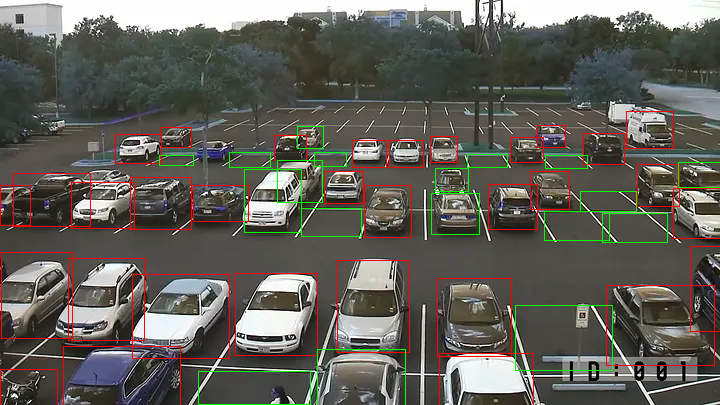

In [48]:
image_path = '/content/drive/MyDrive/Colab Notebooks/parking-lot-1.webp'
image = cv2.imread(image_path)

# RGB conversion and array conversion
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
rgb_image = imgpros.img_to_array(rgb_image)

# Run the image through the Mask R-CNN model to get results.
results = model.detect([rgb_image], verbose=0)

# Mask R-CNN assumes we are running detection on multiple images.
# We only passed in one image to detect, so only grab the first result.
r = results[0]

# Get bounding boxes of cars
parked_car_boxes = get_car_boxes(r['rois'], r['class_ids'])

overlaps = mrcnn.utils.compute_overlaps(pinned_car_boxes, parked_car_boxes)

# for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):
for parking_area, overlap_areas in zip(pinned_car_boxes, overlaps):
    max_IoU_overlap = np.max(overlap_areas)
    y1, x1, y2, x2 = parking_area

    if max_IoU_overlap < 0.25:
        # Parking space not occupied! Draw a green box around it
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)

    else:
        # Parking space is still occupied - draw a red box around it
        cv2.rectangle(image, (int(x1), int(y1)), (int(x1 + (x2 - x1)), int(y1 + (y2 - y1))), (255, 0, 0), 1)

# # Now, let's detect and draw rectangles around cars in the image
# for car_box in parked_car_boxes:
#     y1, x1, y2, x2 = car_box
#     cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 1)

# Display the image with bounding boxes for cars and parking spaces
cv2_imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
cv2.waitKey(0)
cv2.destroyAllWindows()